In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux;

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative C:\Users\jbere\.julia\packages\CUDAnative\ierw8\src\compatibility.jl:176


In [144]:
#Hyperparameters
n = 10
N = 100
σₐ = 0.001
bound = 1

k_range = 20
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] #November 3
k_list_lite = [i for i in 1:k_range]
k_real = 12
k = k_real;

In [3]:
#Functions
function plot_data(data,scores,alpha=1.0)
    scatter(data[:,1],data[:,2],c=scores)
end

mₖ(k) = k*4 + 1;

In [122]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

#Create a Random Network
@gen function generator(x::Array{Float64}, k=12)
    σₖ = 1.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real))
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

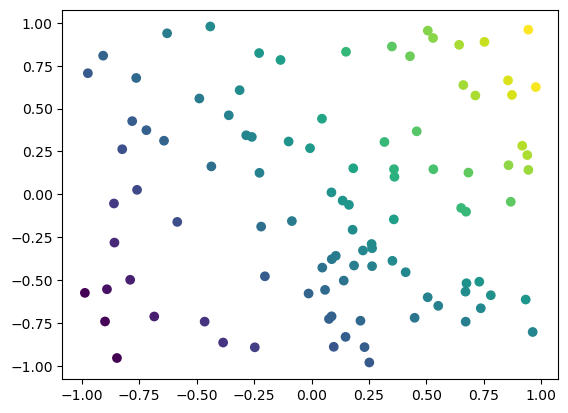

PyObject <matplotlib.collections.PathCollection object at 0x000000006BD426D0>

In [123]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
#data = x
#data_raw = data

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

y_real = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:]
plot_data(x_raw,y_real)

In [134]:
#Classifier Network Tries to Learn the Generator Network

@gen function classifier(x::Array{Float64})
    σₖ = 1.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real))
    #errors = scores - y_real
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.01 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [135]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

print(best_trace[:Wₕ])
print(Wₕ)
best_k = best_trace[:k]

[-0.013646851563452788, -0.8514189949112896, 0.31192957981118175, 0.11503280242625599, 1.4287869930302781, 0.21513945412926075, 0.6731130375140543, 1.3690970166499499, 1.2086338674576682, -0.15001605924477285, -0.6456404111940193, 0.6430667314589554, -0.919484884592915, -0.03936173634355872, -1.0517098548413006, 0.5506050312157884, -0.1965372883477703, 1.5003564519900652, -0.03706585558474311, -0.9693139716192586, 1.6287637006875346, -1.1650137723551555, -0.49827979148925067, -0.11052179159414897, -0.6218968261932863, -0.5505608710016601, -0.35297209379609795, 0.5471050023523389, -0.7545431823676119, -1.5751261109390802, -0.37232836138420566, 0.19711075588871307][-0.5673693715102895, 0.125982625531917, 0.48223951688608646, -0.25248306962631756, -0.8204208478627666, 0.923826807888792, 0.19543323810439653, 0.9866520221624682, -0.016917724105349724, 0.9964300368523671, -0.08632176284485225, -0.2757780965712388, -0.9627587840689804, 0.007286653683695525, -1.3609925297030736, 1.770225201617

16

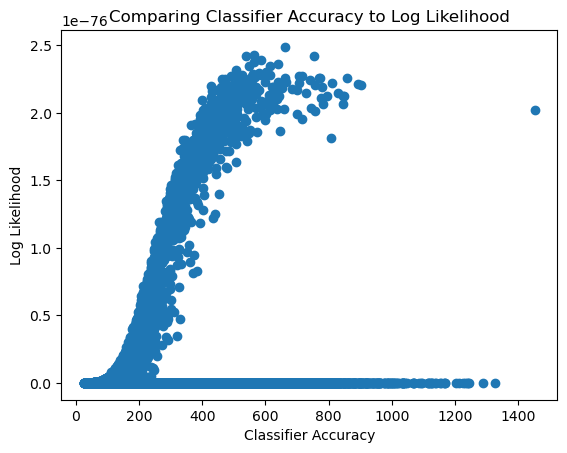

18

In [153]:
#Plot of Log Likelihood Scores
scores = []
distances = []
ks = []
best_ks = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)/length(y_real)
#best_score = exp(get_score(trace)/length(y_real))
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_dist = sqrt(sum((best_pred_y .- y_real) .^ 2))

function likelihood(best_dist)
    (trace,) = generate(classifier, (x,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(x,Wₕ,bₕ,Wₒ,bₒ,k)

    dist = sqrt(sum((pred_y .- y_real) .^ 2))
    score = get_score(trace)/length(y_real)
    #score = exp(get_score(trace)/length(y_real))
    if score > best_score
        best_dist = dist
        best_trace = trace
        best_dist = dist
        best_pred_y = pred_y
        best_k = k
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
end

for i=1:10000
    likelihood(best_dist)
end

scatter(distances,scores)
#plt.xlim(0,250000)
#plt.ylim(-130000000,-129600000)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");
print(best_trace[:k])

In [137]:
obs_new = choicemap()::ChoiceMap
obs_new[:y] = y_real
obs_new[:Wₕ] = Wₕ
obs_new[:Wₒ] = Wₒ
obs_new[:bₕ] = bₕ
obs_new[:bₒ] = bₒ
obs_new[:k] = k_real
(trace,) = generate(classifier, (x,), obs)
args = get_args(trace)
argdiffs = map((_) -> NoChange(), args)

(new_trace, weight, _, _) = update(best_trace, args, argdiffs, obs_new)

println(get_score(best_trace))
println(get_score(new_trace))

-24715.42158813188
-18397.604559280553


In [138]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:Wₕ] = vcat(Wₕ,[rand(1)[1] for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[rand(1)[1] for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[rand(1)[1] for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    #(new_trace, weight) = generate(classifier, (x,), obs_new)
    (new_trace, weight, _, _) = update(trace, args, argdiffs, obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    #(new_trace, weight) = generate(classifier, (x,), obs_new)
    (new_trace, weight, _, _) = update(trace, args, argdiffs, obs_new)
    return new_trace
end;

In [139]:
get_score(best_trace)
score1 = exp(get_score(best_trace)/length(y_real))

4.5950248416961974e-108

In [150]:
traces = []
acc = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=5, eps=0.06, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    #selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    #args = get_args(trace)
    #argdiffs = map((_) -> NoChange(), args)
    #(new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:10
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=5, eps=0.06, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(y_real))
    score2 = exp(get_score(new_trace)/length(y_real))
    score = score2/score1
    #println(score1)
    #println(score2)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        #println("Sticking with the old k!")
        accepted = false
        push!(acc,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        if i%100 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
starting_trace = best_trace
#(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,5000);

Beginning RJMCMC. Starting k: 4
Epoch 100 Acceptance Prob: 0.647887323943662
Epoch 200 Acceptance Prob: 0.8213058419243986
Epoch 300 Acceptance Prob: 0.8681818181818182
Epoch 400 Acceptance Prob: 0.8875838926174496
Epoch 500 Acceptance Prob: 0.9010840108401084
Epoch 600 Acceptance Prob: 0.9177927927927928
Epoch 700 Acceptance Prob: 0.9297401347449471
Epoch 800 Acceptance Prob: 0.9349662162162162
Epoch 900 Acceptance Prob: 0.9406015037593985
Epoch 1000 Acceptance Prob: 0.9443312966734555
Epoch 1100 Acceptance Prob: 0.9489230769230769
Epoch 1200 Acceptance Prob: 0.952058657642414
Epoch 1300 Acceptance Prob: 0.9526288391462779
Epoch 1400 Acceptance Prob: 0.9524038461538461
Epoch 1500 Acceptance Prob: 0.9547491039426523
Epoch 1600 Acceptance Prob: 0.9551362683438155
Epoch 1700 Acceptance Prob: 0.9542947202521671
Epoch 1800 Acceptance Prob: 0.9568452380952381
Epoch 1900 Acceptance Prob: 0.9590540063536886
Epoch 2000 Acceptance Prob: 0.9607514256960752
Epoch 2100 Acceptance Prob: 0.962595907

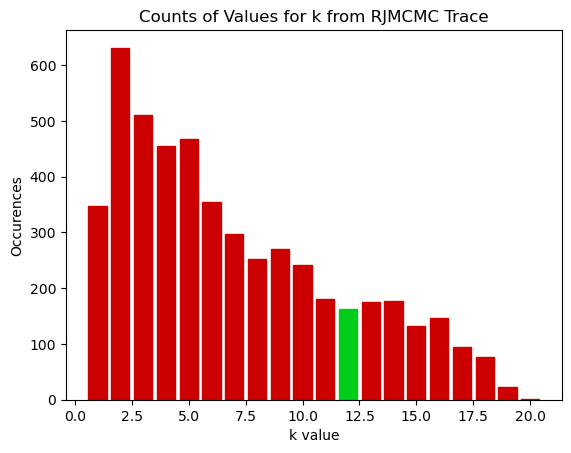

In [151]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[12].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");